# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [7]:
# number of callbacks for white-sounding names
print('Total white applications:', len(data[data.race=='w']))
print('Total white callbacks:', sum(data[data.race=='w'].call))

Total white applications: 2435
Total white callbacks: 235.0


In [8]:
# number of callbacks for black-sounding names
print('Total black applications:', len(data[data.race=='b']))
print('Total black callbacks:', sum(data[data.race=='b'].call))

Total black applications: 2435
Total black callbacks: 157.0


In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

In [11]:
w = data[data.race=='w']
b = data[data.race=='b']

In [13]:
print('White callback rate:', np.mean(w.call))
print('Black callback rate:', np.mean(b.call))

White callback rate: 0.09650924056768417
Black callback rate: 0.0644763857126236


## 1. What test is appropriate for this problem?
#### An independent samples t-test would be appropriate here because we have two samples for which we would like to compare mean values.
## 1. Does CLT apply?
#### Yes, the Central Limit Theorem applies because because we have a sufficient sample size such that we can assume that the sampling distribution approximates the normal distribution. Therefor we can apply tests that assume a normal distribution. 
## 2. What are the null and alternate hypotheses?
#### H0: The callback rates for blacks and whites are identical.
#### H1: The callback rates for blacks and whites are not identical.

<div class="span5 alert alert-success">
<p> Your solution to Q3 here </p>
</div>


## 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
#### First, some graphical EDA

In [23]:
# Define functions to be used later.

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y
    
def perform_bernoulli_trials(n, p):
    """Perform n Bernoulli trials with success probability p
    and return number of successes."""
    # Initialize number of successes: n_success
    n_success = 0

    # Perform trials
    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = np.random.random()

        # If less than p, it's a success so add one to n_success
        if random_number < p:
            n_success += 1

    return n_success

In [27]:
# Perform Bernoulli trials to simulate the study 1000 times using the callback rate as the probability of success
n_callbacks_w = np.empty(1000)

for i in range(1000):
    n_callbacks_w[i] = perform_bernoulli_trials(len(w), np.mean(w.call))

n_callbacks_b = np.empty(1000)

for i in range(1000):
    n_callbacks_b[i] = perform_bernoulli_trials(len(b), np.mean(b.call))

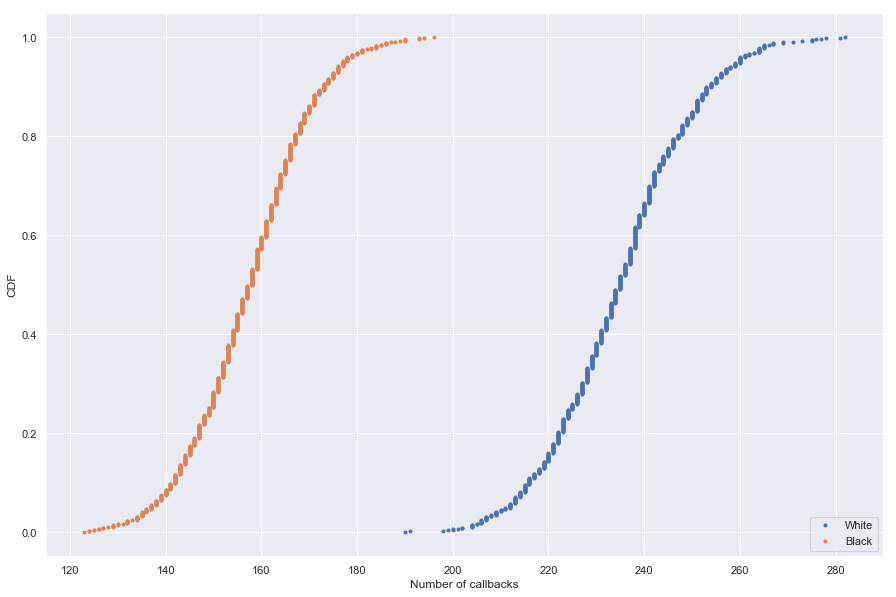

In [39]:
# Plot the ecdf for blacks and whites
x_w, y_w = ecdf(n_callbacks_w)
x_b, y_b = ecdf(n_callbacks_b)

plt.plot(x_w, y_w, marker='.', linestyle='none')
plt.plot(x_b, y_b, marker='.', linestyle='none')
plt.xlabel('Number of callbacks')
plt.ylabel('CDF')
plt.legend(('White', 'Black'), loc='lower right')
plt.show()

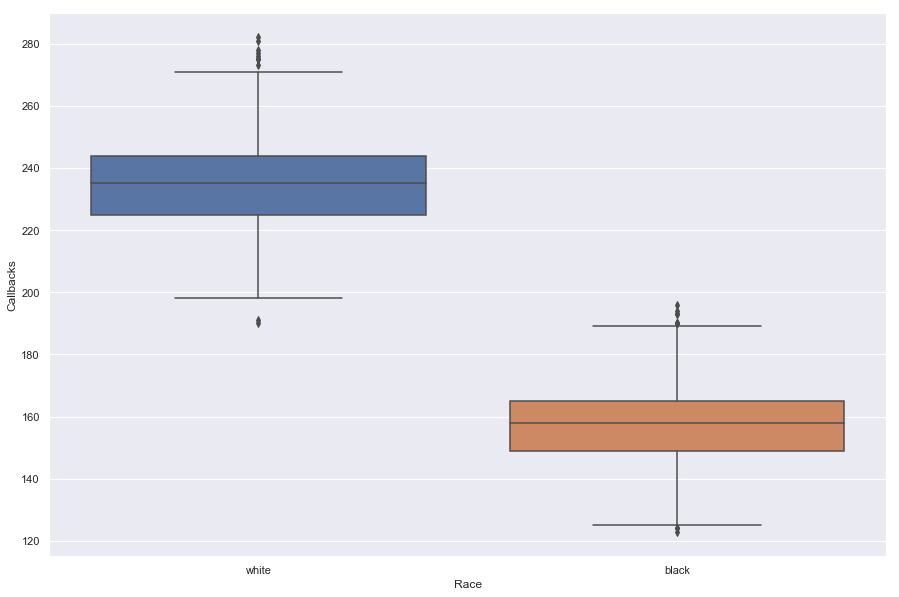

In [40]:
df_w = pd.DataFrame({'Callbacks': n_callbacks_w, 'Race': 'white'})
df_b = pd.DataFrame({'Callbacks': n_callbacks_b, 'Race': 'black'})
df = pd.concat([df_w, df_b])

sns.boxplot(x='Race', y='Callbacks', data=df)

## After simulating the study 1000 times, we can see that there is very little overlap between the black and white samples. Blacks consistently receive fewer callbacks than whites.
### Let's compute the margin of error and 95% confidence interval for each.
### Bootstrap approach

In [42]:
w_replicates = draw_bs_reps(w.call, np.mean, size=10000)
b_replicates = draw_bs_reps(b.call, np.mean, size=10000)

In [48]:
MOE_w = np.percentile(w_replicates, [97.5])[0] - np.mean(w_replicates)
MOE_b = np.percentile(b_replicates, [97.5])[0] - np.mean(b_replicates)
print('White Callback Rate\nMean:', np.mean(w_replicates),
      '\nMargin of Error:', MOE_w, 
      '\n95% Confidence Interval:', np.percentile(w_replicates, [2.5, 97.5]))
print('\nBlack Callback Rate\nMean:', np.mean(b_replicates), 
      '\nMargin of Error:', MOE_b, 
      '\n95% Confidence Interval:', np.percentile(b_replicates, [2.5, 97.5]))

White Callback Rate
Mean: 0.09643355235159397 
Margin of Error: 0.011985336992144588 
95% Confidence Interval: [0.08501027 0.10841889]

Black Callback Rate
Mean: 0.06449696087241173 
Margin of Error: 0.009835686153173442 
95% Confidence Interval: [0.0550308  0.07433265]


#### We can be 95% confident that the true white callback rate is between 0.085 and 0.108. We can be 95% confident that the true black callback rate is between 0.055 and 0.074.
#### Because these confidence intervals do not overlap, it is safe to assume that the true callback rates are not equal.
#### Another approach using permutation replicates:

In [50]:
perm_replicates = np.empty(10000)

observed_diff = np.mean(w.call) - np.mean(b.call)

for i in range(10000):
    permutation_samples = np.random.permutation(np.concatenate((w.call, b.call)))
    
    white_perm = permutation_samples[:len(w)]
    black_perm = permutation_samples[len(w):]
    
    perm_replicates[i] = np.abs(np.mean(white_perm) - np.mean(black_perm))
    
p = np.sum(perm_replicates >= observed_diff) / len(perm_replicates)
print('p-value:', p)

p-value: 0.0


#### None of the 10,000 permutation replicates had a callback rate difference at least as large as the observed difference. We can therefor reject the null hypothesis that the callback rates for blacks and whites are equal.
****
### Frequentist approach

In [53]:
SEM_w = np.std(w.call) / np.sqrt(len(w))
SEM_b = np.std(b.call) / np.sqrt(len(b))

MOE_w = SEM_w * 1.96
MOE_b = SEM_b * 1.96

conf_int_w = [np.mean(w.call) - MOE_w, np.mean(w.call) + MOE_w]
conf_int_b = [np.mean(b.call) - MOE_b, np.mean(b.call) + MOE_b]

print('White Callback Rate\nMean:', np.mean(w.call),
     '\nMargin of Error:', MOE_w,
     '\n95% Confidence Interval:', conf_int_w)
print('\nBlack Callback Rate\nMean:', np.mean(b.call),
     '\nMargin of Error:', MOE_b,
     '\n95% Confidence Interval:', conf_int_b)

White Callback Rate
Mean: 0.09650924056768417 
Margin of Error: 0.011728643328433408 
95% Confidence Interval: [0.08478059723925077, 0.10823788389611758]

Black Callback Rate
Mean: 0.0644763857126236 
Margin of Error: 0.00975513338480545 
95% Confidence Interval: [0.054721252327818146, 0.07423151909742905]


In [54]:
stats.ttest_ind(w.call, b.call)

Ttest_indResult(statistic=4.114705290861751, pvalue=3.940802103128886e-05)

#### Again, the 95% confidence intervals do not overlap. Also the p-value of an independent samples t-test is less than 0.05 so we can reject the null hypothesis that the callback rates are equal.

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

## 4.Write a story describing the statistical significance in the context or the original problem.
#### Both the bootstrap and freuquentist approaches show that the difference in callback rates between blacks and whites is statistically significant (p<0.05). Because the study was designed such that the applications were identical except for the sound of the names (black or white), we can conclude that race plays a significant role in whether an applicant receives a callback. 
#### Having a white sounding name is associated with a 50% higher callback rate compared to having a black sounding name.

****
## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
#### The analysis does not necessarily suggest that race/name is the most important factor in callback success. The applications varied in other characteristics such as previous work experience and skills, so one would need to analyze how those characteristics affect callback success to determine which characteristic is more important.
#### One way to do this would be to perform a regression with each of the variables included and interpret each of the coefficients individually.